# Demonstration of the QLSAs workflow, following the qiskit patterns framework

In [1]:
# Set system path

from pathlib import Path
import sys


def find_repo_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for d in (p, *p.parents):
        if (d / ".git").exists() or (d / "pyproject.toml").exists() or (d / "src").exists():
            return d
    return p  # fallback


repo_root = find_repo_root()
print(repo_root)

# This repo uses a "src layout" (the Python package lives in <repo>/src/qlsas),
# but the repo is not installed as a package. Add <repo>/src to sys.path.
src_dir = repo_root / "src"
if src_dir.exists() and str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

# Also add the repo root so you can import top-level modules like
# `linear_systems_problems.random_matrix_generator`.
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

/Users/adrianharkness/QCOL_COPT/HHL/QLSAs


In [2]:
# Import QLSAs modules

from qlsas.qlsa.hhl import HHL
from qlsas.data_loader import StatePrep
from qlsas.transpiler import Transpiler
from qlsas.executer import Executer
from qlsas.post_processor import Post_Processor
from qlsas.solver import QuantumLinearSolver
from qlsas.refiner import Refiner
from linear_systems_problems.random_matrix_generator import generate_problem

import numpy as np
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.primitives import StatevectorSampler
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_distribution
from qiskit_ibm_runtime import IBMBackend
from qiskit_aer import AerSimulator
from qiskit.providers.backend import BackendV1, BackendV2


## Step 0: **Define** the (classical) problem

In [3]:
prob = generate_problem(n=16, cond_number=5.0, sparsity=0.5, seed=0)
A, b = prob["A"], prob["b"]

A  = A / np.linalg.norm(b)
b = b / np.linalg.norm(b)

print(f"A: {A}")
print()
print(f"b: {b}")


A: [[ 6.70638146e-01 -9.39105771e-17  1.68877511e-01 -9.39105771e-17
  -3.10240299e-17  4.02935755e-02 -4.17511298e-04  1.63040870e-01
  -1.09652204e-01 -4.64845406e-02 -1.08584105e-16 -6.33057908e-17
   2.85085680e-17  6.08951398e-17  2.47889343e-02  2.02075438e-16]
 [-9.39105771e-17  8.63406422e-01  1.34157967e-17 -1.16786338e-01
   1.22231361e-01 -8.04947804e-17 -8.72026787e-17 -1.60989561e-16
  -2.68315935e-17 -9.02421952e-17  6.00304672e-02 -2.05085904e-02
  -2.17938393e-01  3.87371971e-03 -5.36631869e-17  2.01236951e-17]
 [ 1.68877511e-01  1.34157967e-17  8.98285851e-01  5.06965409e-02
   1.74405357e-16  1.83746191e-01  1.36668593e-01 -8.31779397e-16
   1.23272175e-01 -2.44838290e-16 -1.81113256e-16  2.06401446e-02
  -6.03710853e-17  8.17525113e-18  1.41908709e-01 -1.21494250e-02]
 [-9.39105771e-17 -1.16786338e-01  5.06965409e-02  8.03693581e-01
  -1.76082332e-17 -4.02473902e-17  2.01212237e-02 -3.45456766e-16
   1.50927713e-16 -7.25291511e-17  8.38487296e-17 -6.96924246e-02
  -6

## Step 1: **Map** problem to quantum circuits and operators

In [4]:
hhl = HHL(
    state_prep = StatePrep(method='default'), 
    readout = 'measure_x',
    #swap_test_vector = np.ones(len(b)) / np.linalg.norm(np.ones(len(b))),
    num_qpe_qubits = math.log2(len(b)),
    t0 = 2 * np.pi)

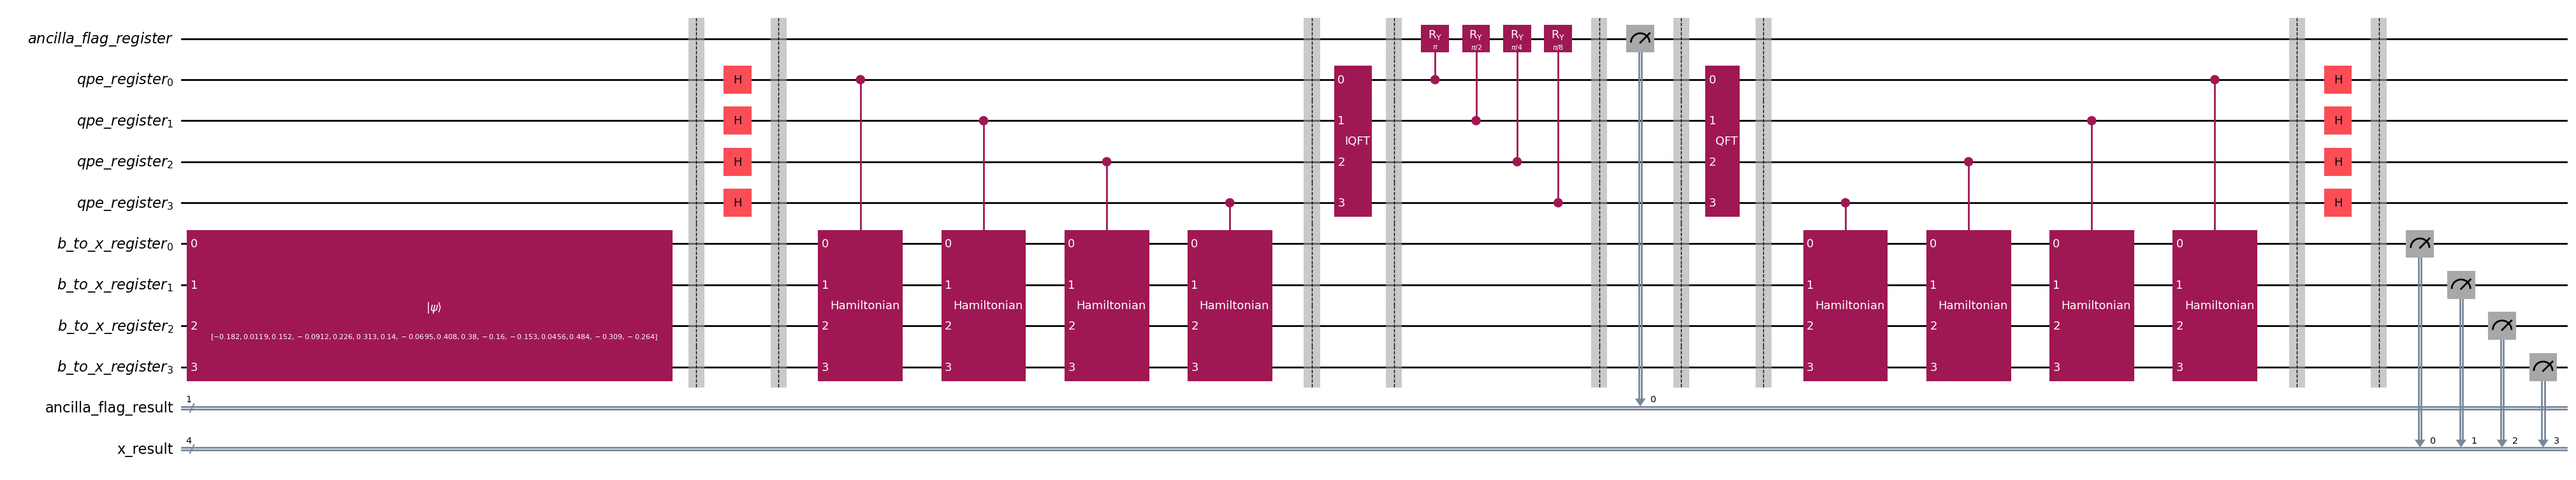

In [5]:
hhl_circuit = hhl.build_circuit(A, b)
hhl_circuit.draw(output='mpl', fold=-1)

## Step 2: **Optimize** for target hardware

In [6]:
service = QiskitRuntimeService(name="QLSAs")
service.backends()

[<IBMBackend('ibm_pittsburgh')>,
 <IBMBackend('ibm_boston')>,
 <IBMBackend('ibm_fez')>,
 <IBMBackend('ibm_torino')>,
 <IBMBackend('ibm_miami')>,
 <IBMBackend('ibm_marrakesh')>,
 <IBMBackend('ibm_kingston')>]

In [7]:
# Define a backend

service = QiskitRuntimeService(name="QLSAs")

#backend = service.backend("ibm_boston")

# backend = service.least_busy(
#     operational=True,
#     min_num_qubits=hhl_circuit.num_qubits
# )
# print("Backend: ", backend)

backend = AerSimulator()

transpiler = Transpiler(circuit=hhl_circuit, backend=backend, optimization_level=3)
transpiled_hhl_circuit = transpiler.optimize()

print(f"2q-depth:        {transpiled_hhl_circuit.depth(lambda x: x.operation.num_qubits==2)}")
print(f"2q-size:         {transpiled_hhl_circuit.size(lambda x: x.operation.num_qubits==2)}")
print(f"Operator counts: {transpiled_hhl_circuit.count_ops()}")

2q-depth:        1672
2q-size:         1680
Operator counts: OrderedDict([('cu', 1280), ('ccx', 800), ('cp', 396), ('h', 16), ('barrier', 9), ('p', 8), ('measure', 5), ('cry', 4), ('initialize', 1)])


## Step 3: **Execute** on target hardware

In [8]:
executer = Executer()

result = executer.run(
    transpiled_circuit = transpiled_hhl_circuit, 
    backend = backend, 
    shots = 250
    )

>>> Job ID: 6a781b17-40a7-4260-982d-163f1f81ac7d
>>> Job Status: JobStatus.RUNNING...
>>> Job Status: JobStatus.DONE


## Step 4: **Process** result to obtain classical solution

In [9]:
processor = Post_Processor()
solution = processor.process(result, A, b)
solution

array([-0.24052285,  0.        , -0.27272727, -0.        ,  0.48104569,
        0.25712974,  0.09090909,  0.09090909,  0.4979296 ,  0.39626354,
       -0.20327891, -0.        ,  0.12856487,  0.20327891, -0.22268089,
       -0.        ])

## Wrapping steps 1-4 together in a solver:

In [10]:
hhl_solver = QuantumLinearSolver(
    qlsa = hhl,
    backend = backend,
    shots = 250,
    optimization_level = 3,
    executer = executer,
    post_processor = processor)

hhl_solution = hhl_solver.solve(A, b)
print(f"Solution: {hhl_solution}")

>>> Job ID: 6062f17a-6373-4456-a490-71f666b564fe
>>> Job Status: JobStatus.RUNNING...
>>> Job Status: JobStatus.DONE
Solution: [-0.29277002  0.09759001 -0.09759001 -0.09759001  0.36514837  0.25819889
  0.          0.23904572  0.54335816  0.36514837 -0.13801311 -0.13801311
  0.16903085  0.25819889 -0.23904572 -0.09759001]


## Integrate **Iterative Refinement** to improve accuracy

IR Iteration: 0
>>> Job ID: 220ca02e-7e1a-4a62-ae43-3359b23072fa
>>> Job Status: JobStatus.RUNNING...
>>> Job Status: JobStatus.DONE
  residual: 0.7937, error: 0.9251, alpha: 0.7339

IR Iteration: 1
>>> Job ID: fa1cd9a7-3e3f-4478-8b79-4528e004dee1
>>> Job Status: JobStatus.RUNNING...
>>> Job Status: JobStatus.DONE
  residual: 0.5956, error: 0.6195, alpha: 0.7859

IR Iteration: 2
>>> Job ID: cbc0ab72-289b-46a0-81ab-3f0e92ad1e98
>>> Job Status: JobStatus.RUNNING...
>>> Job Status: JobStatus.DONE
  residual: 0.4549, error: 0.3773, alpha: 1.1955

IR Iteration: 3
>>> Job ID: 159e8fdd-2d40-4f07-8c07-23477d299a4b
>>> Job Status: JobStatus.RUNNING...
>>> Job Status: JobStatus.DONE
  residual: 0.4034, error: 0.3146, alpha: 0.5937

IR Iteration: 4
>>> Job ID: d95be3dc-88aa-4723-b274-9d4bbc122a1b
>>> Job Status: JobStatus.RUNNING...
>>> Job Status: JobStatus.DONE
  residual: 0.3917, error: 0.3046, alpha: 0.3492

IR Iteration: 5
>>> Job ID: a0e8f84a-042a-45bc-ac6b-cdb465d74ad7
>>> Job Status: JobS

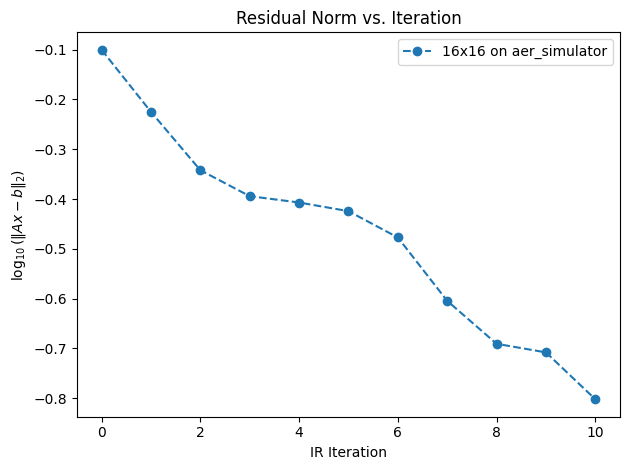

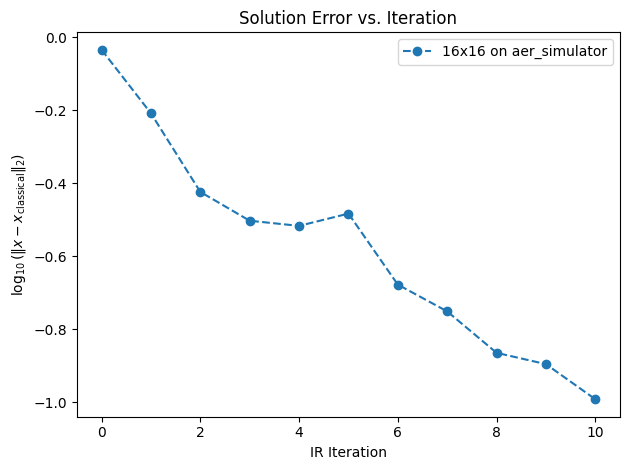

In [11]:
refiner = Refiner(A = A, b = b, solver = hhl_solver)

refined_solution = refiner.refine(precision = 1e-6, max_iter = 10, plot=True)